c:\Users\Irshad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


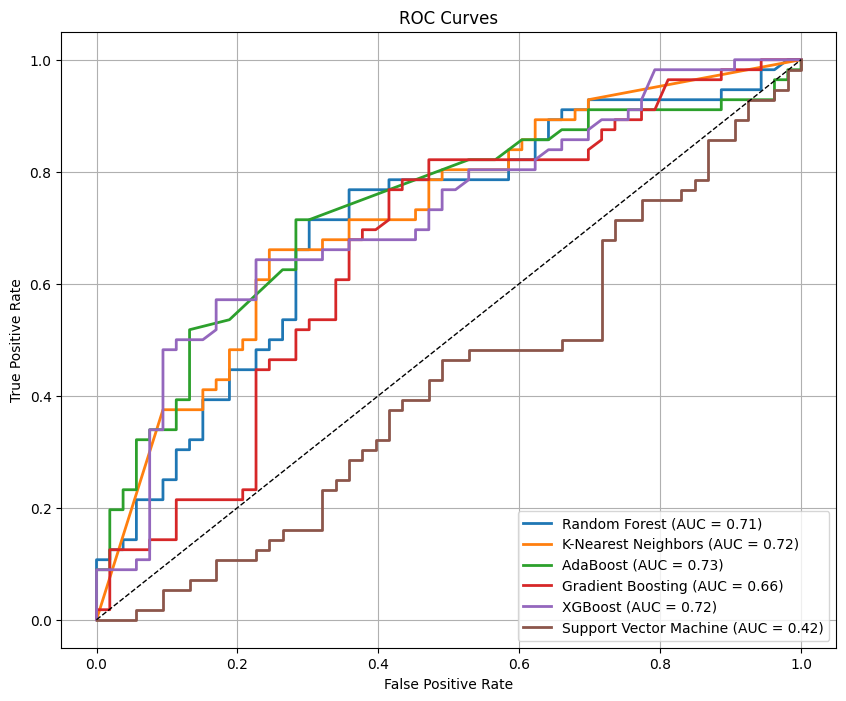


Performance Metrics:



,Model,Accuracy,Precision,Recall,F1 Score,Sensitivity,Specificity,PPV,NPV,AUC,Best Parameters
0,Random Forest,0.697248,0.682540,0.767857,0.722689,0.767857,0.622642,0.682540,0.717391,0.705020,"{'max_depth': 30, 'min_samples_split': 2, 'n_e..."
1,K-Nearest Neighbors,0.633028,0.625000,0.714286,0.666667,0.714286,0.547170,0.625000,0.644444,0.722877,"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}"
2,AdaBoost,0.678899,0.705882,0.642857,0.672897,0.642857,0.716981,0.705882,0.655172,0.731806,"{'learning_rate': 1, 'n_estimators': 100}"
3,Gradient Boosting,0.669725,0.647059,0.785714,0.709677,0.785714,0.547170,0.647059,0.707317,0.660209,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti..."
4,XGBoost,0.623853,0.611940,0.732143,0.666667,0.732143,0.509434,0.611940,0.642857,0.719845,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
5,Support Vector Machine,0.513761,0.513761,1.000000,0.678788,1.000000,0.000000,0.513761,0.000000,0.423518,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}"



Confusion Matrices:

Confusion Matrix for Random Forest:
[[33 20]
 [13 43]]

Confusion Matrix for K-Nearest Neighbors:
[[29 24]
 [16 40]]

Confusion Matrix for AdaBoost:
[[38 15]
 [20 36]]

Confusion Matrix for Gradient Boosting:
[[29 24]
 [12 44]]

Confusion Matrix for XGBoost:
[[27 26]
 [15 41]]

Confusion Matrix for Support Vector Machine:
[[ 0 53]
 [ 0 56]]



In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, roc_curve, f1_score)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Load the dataset from the specified file path
file_path = 'Dataset/Train/eeg_features_.xlsx'
data = pd.read_excel(file_path)

# Separates the dataset into features (X) and labels (y)
X = data.drop(columns='label')  # Features
y = data['label']  # Target variable

# Scaling the features to have mean = 0 and variance = 1, which is important for some algorithms
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splits the dataset into training and testing sets
# stratify=y ensures that the proportion of labels in the train and test sets are the same
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Defined a dictionary of models with their hyperparameter grids for GridSearchCV
models = {
    "Random Forest": (RandomForestClassifier(random_state=42), {
        'n_estimators': [1000, 1500],  # Number of trees in the forest
        'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
        'min_samples_split': [2, 5]  # Minimum number of samples required to split an internal node
    }),
    "K-Nearest Neighbors": (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],  # Number of neighbors to use
        'weights': ['uniform', 'distance'],  # Weight function used in prediction
        'p': [1, 2]  # Power parameter for the Minkowski metric (1: Manhattan, 2: Euclidean)
    }),
    "AdaBoost": (AdaBoostClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],  # Number of boosting stages to perform
        'learning_rate': [0.01, 0.1, 0.5, 1]  # Weight applied to each classifier at each boosting iteration
    }),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42), {
        'n_estimators': [100, 200],  # Number of boosting stages to perform
        'max_depth': [3, 5],  # Maximum depth of the individual regression estimators
        'learning_rate': [0.01, 0.1, 0.2]  # Learning rate shrinks the contribution of each tree
    }),
    "XGBoost": (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
        'n_estimators': [100, 200, 300],  # Number of gradient boosted trees
        'max_depth': [3, 5, 7],  # Maximum tree depth for base learners
        'learning_rate': [0.01, 0.1, 0.2]  # Boosting learning rate
    }),
    "Support Vector Machine": (SVC(probability=True, random_state=42), {
        'C': [0.1, 1, 10],  # Regularization parameter
        'kernel': ['linear', 'rbf'],  # Specifies the kernel type to be used in the algorithm
        'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    })
}

# Initializes a list to store the results of each model for comparison
results = []

# Dictionary path to store ROC curve data for each model
roc_curves = {}

# Train and evaluate each model using GridSearchCV
for model_name, (model, param_grid) in models.items():
    # Perform grid search with cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)

    # Retrieve the best model based on grid search
    best_model = grid_search.best_estimator_

    # predictions on the test set
    y_pred = best_model.predict(X_test)

    # Gets the predicted probabilities for the positive class
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Calculating evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)  # Overall accuracy
    precision = precision_score(y_test, y_pred, pos_label=1)  # Precision for positive class
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for positive class
    f1 = f1_score(y_test, y_pred, pos_label=1)  # F1 score for positive class
    sensitivity = recall_score(y_test, y_pred, pos_label=1)  # True positive rate
    specificity = recall_score(y_test, y_pred, pos_label=0)  # True negative rate
    ppv = precision_score(y_test, y_pred, pos_label=1)  # Positive predictive value
    npv = precision_score(y_test, y_pred, pos_label=0)  # Negative predictive value
    auc = roc_auc_score(y_test, y_proba)  # Area under the ROC curve
    cm = confusion_matrix(y_test, y_pred)  # Confusion matrix

    # Stores ROC curve data for plotting
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_curves[model_name] = (fpr, tpr, auc)

    # Stores the results in a dictionary and append to the results list
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "PPV": ppv,
        "NPV": npv,
        "AUC": auc,
        "Confusion Matrix": cm,
        "Best Parameters": grid_search.best_params_
    })

    # Shows the confusion matrix using a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Saves the confusion matrix plot as a PNG file
    plt.savefig(f'Performance Metrics/confusion_matrix_{model_name.replace(" ", "_")}.png')
    plt.close()

# Converts the results into a DataFrame for easy viewing and analysis
results_df = pd.DataFrame(results)

# Saves the performance metrics (excluding confusion matrices) to an Excel file
results_df.drop(columns=["Confusion Matrix"]).to_excel('Performance Metrics/performance_metrics.xlsx', index=False)

# Plot ROC curves for each model
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})", linewidth=2)

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

# Adding labels and title to the ROC plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)

# Saves the ROC curves plot as a PNG file
plt.savefig('Performance Metrics/roc_curves.png')

# Display the ROC curves plot
plt.show()

# Print the performance metrics table (excluding confusion matrices)
print("\nPerformance Metrics:\n")
display(results_df.drop(columns=["Confusion Matrix"]))

# Print the confusion matrix for each algorithm separately at the end
print("\nConfusion Matrices:\n")
for result in results:
    model_name = result["Model"]
    cm = result["Confusion Matrix"]
    print(f"Confusion Matrix for {model_name}:\n{cm}\n")
